In [103]:
#Импорты библиотек
import pandas as pd
import numpy as np

from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

from imblearn.under_sampling import RandomUnderSampler

import warnings 
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import xgboost
import catboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

from sklearn import preprocessing

In [104]:
random_seed = 42

## Описание

В этом решении будем использовать несколько временных рядов одного пилота для обучения и на другом временном ряде этого же пилота проведем тест. Будем использовать пилота с id = 1.

## Считываем данные

Определим функцию для формирования данных.

In [105]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

Считываем четыре временных ряда, на трех проведем обучения, а тест не четвертом.

In [106]:
#Имена файлов
files_names = ['2023-05-15_16-16-08.palm', '2023-05-15_17-12-24.palm', '2023-06-05_16-12-38.palm', '2023-06-05_17-53-01.palm']
#Признаки, которые необходимо удалить
drop_features = ['ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'ts']
#Список, в котором будем хранить датасеты
data_list = []
#Формируем список, в котором будут храниться наши датасеты
for idx, path in enumerate(files_names):
    #Добавляем датасет в список
    data_list.append(read_omg_csv(f'./data/{path}',
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0))
    #Удаляем ненужные признаки
    data_list[idx] = data_list[idx].drop(drop_features, axis=1)
    
#Посмотрим на один из датасетов
data_list[0].head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,SYNC
0,2,4,3,843,1831,1,1387,2,4,1,...,25,26,3,13,1,11,18,40,30,0
1,5,5,4,840,1834,0,1391,3,0,4,...,23,20,10,11,1,10,16,38,28,0
2,6,3,4,838,1830,3,1388,4,1,4,...,24,17,10,12,1,11,17,36,28,0
3,0,2,3,832,1826,1,1383,4,0,4,...,20,24,10,14,1,9,18,35,25,0
4,6,3,7,840,1834,2,1391,5,3,5,...,22,16,9,10,0,11,14,32,27,0


Теперь нам необходимо сформировать таргет, будем использовать то же кодирование, что и в первом варианте решения.

0 - (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

1 - (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)

2 - (0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)

3 - (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

4 - (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

5 - (1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)

* Neutral - 0
* Open - 1
* Pistol - 2
* Thumb - 3
* OK - 4
* Grab - 5

In [107]:
#Кодировщик
encoder = {
    '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)': 0,
    '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)': 1,
    '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)': 2,
    '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)': 3,
    '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)': 4,
    '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)': 5
}
#Список переменных, которые нужны при кодировании
features_names = ["Thumb", "Index", "Middle", "Ring", "Pinky", 'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']
#Список, в котором будем хранить датасеты с таргетом
data_target_list = []
#Формируем список датасетов с таргетом
for idx, path in enumerate(files_names):
    #Добавляем датасет в список
    data_target_list.append(pd.read_csv(f'./data/{path}.protocol.csv', index_col=0))
    #Формируем признак закодированного жеста
    data_target_list[idx]['gesture'] = data_target_list[idx][features_names].apply(lambda row: encoder[str(tuple(row))], axis=1)
    
data_target_list[0].head()

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation,gesture
epoch,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1


Теперь добавляем к обучающим данным столбец с таргетом.

In [108]:
for idx, data in enumerate(data_list):
    #Формируем целевой признак
    data['gesture'] = data['SYNC'].apply(lambda x: data_target_list[idx]['gesture'].loc[x])
    #Удаляем ненужный столбец
    data_list[idx] = data.drop('SYNC', axis=1)
    
data_list[0].head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,gesture
0,2,4,3,843,1831,1,1387,2,4,1,...,25,26,3,13,1,11,18,40,30,0
1,5,5,4,840,1834,0,1391,3,0,4,...,23,20,10,11,1,10,16,38,28,0
2,6,3,4,838,1830,3,1388,4,1,4,...,24,17,10,12,1,11,17,36,28,0
3,0,2,3,832,1826,1,1383,4,0,4,...,20,24,10,14,1,9,18,35,25,0
4,6,3,7,840,1834,2,1391,5,3,5,...,22,16,9,10,0,11,14,32,27,0


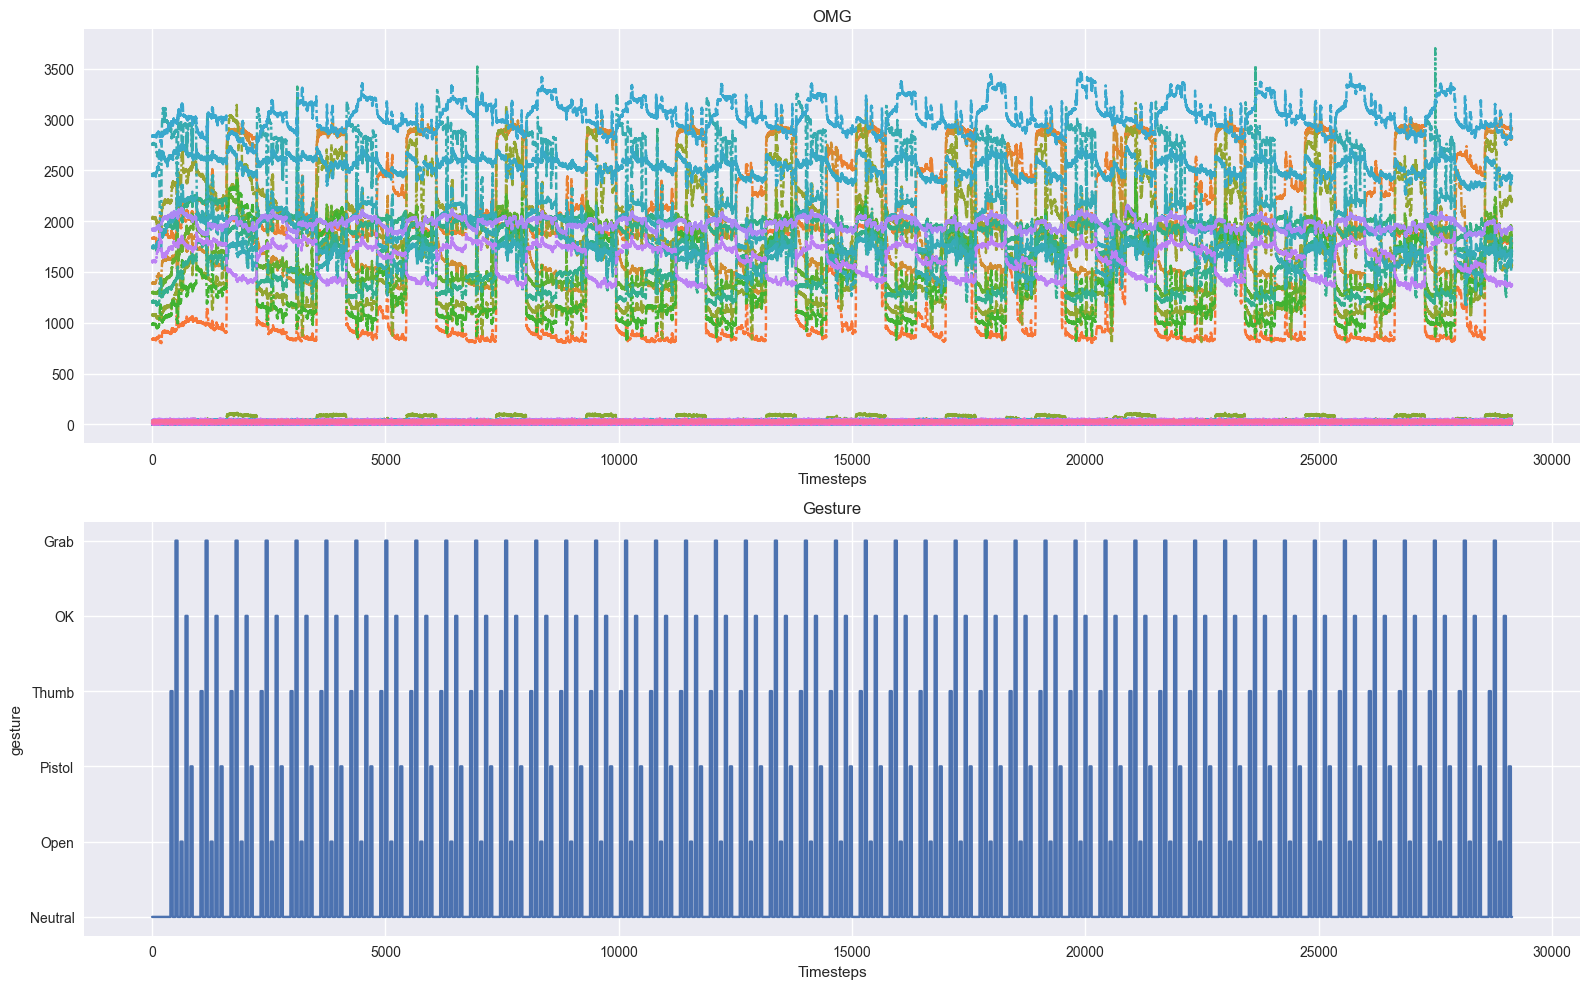

In [109]:
#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data_list[0].drop('gesture', axis=1), ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data_list[0]['gesture'], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

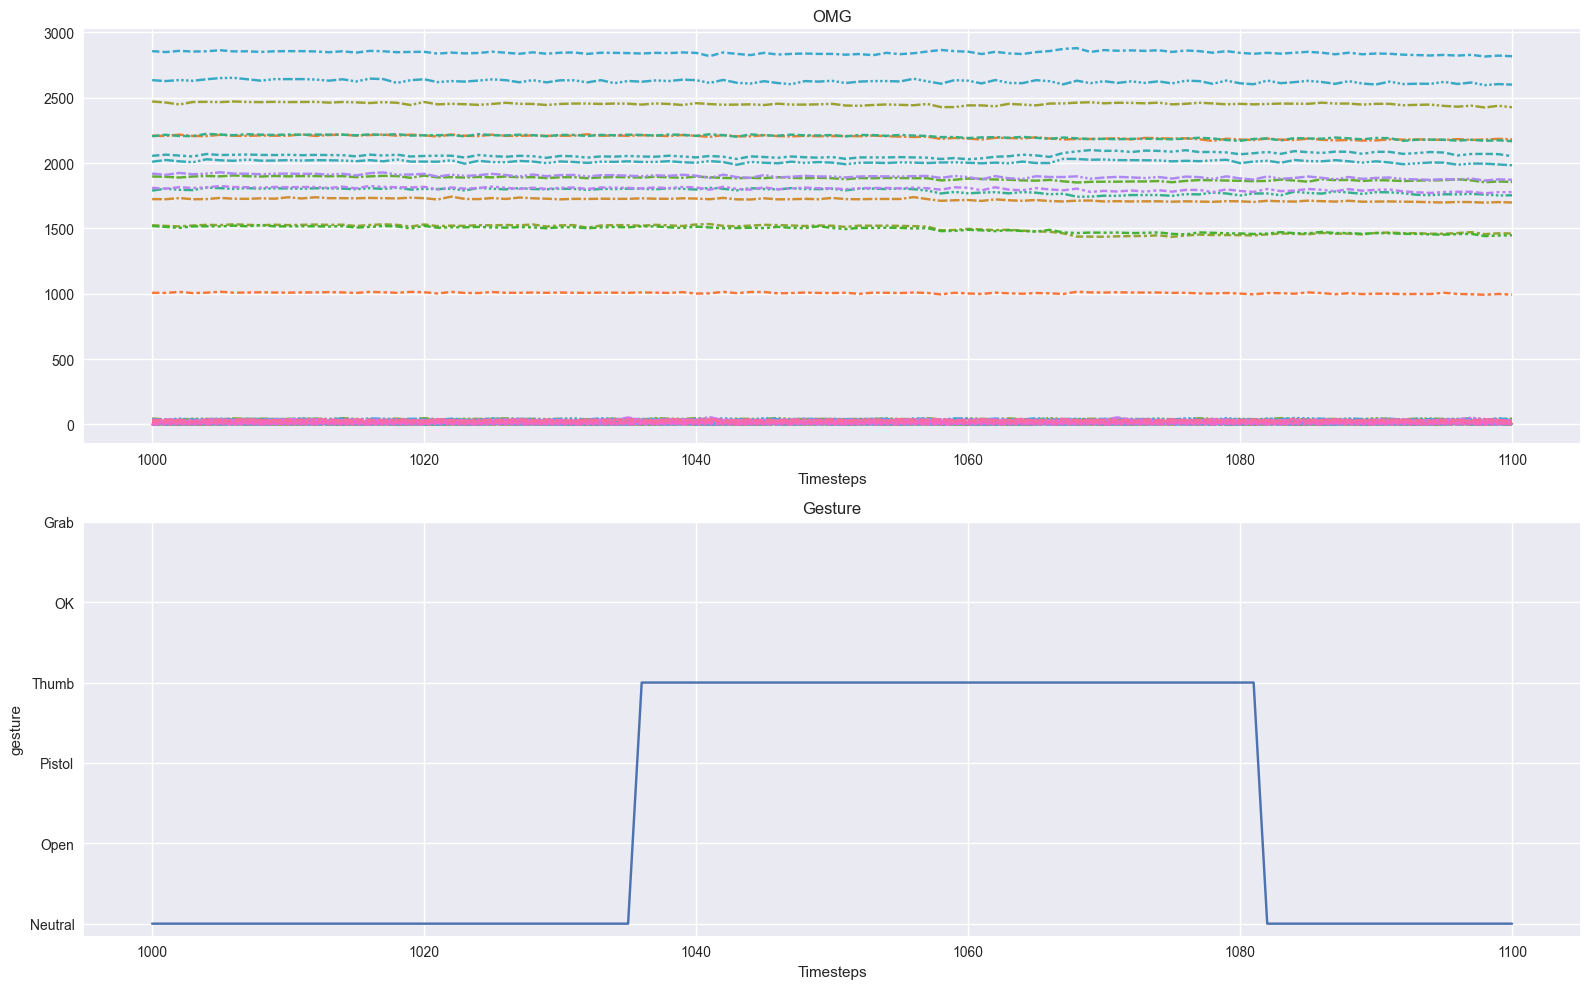

In [110]:
sample_number = 10

#Имена жестов
gestures_names = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(data_list[0].drop('gesture', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(data_list[0]['gesture'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(gestures_names)), gestures_names)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

## Удаление задержки

Избавимся от задержки в каждом датасете, будем делать это изолированно.

n: 18, cor: 0.2602410261445444
n: 16, cor: 0.05794113538350789
n: 14, cor: 0.3493344356602204
n: 13, cor: 0.33674665598950776


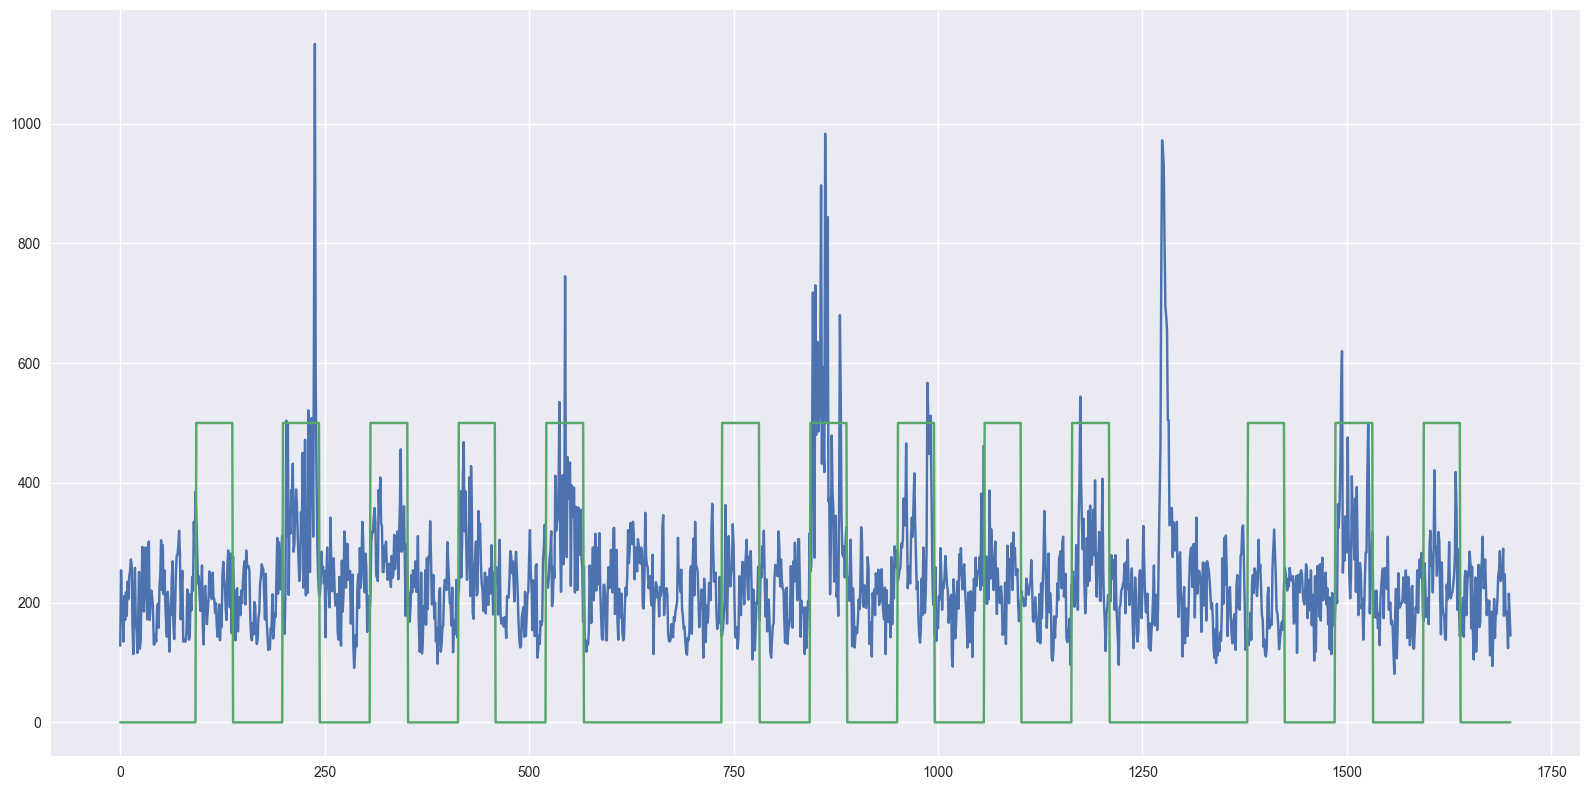

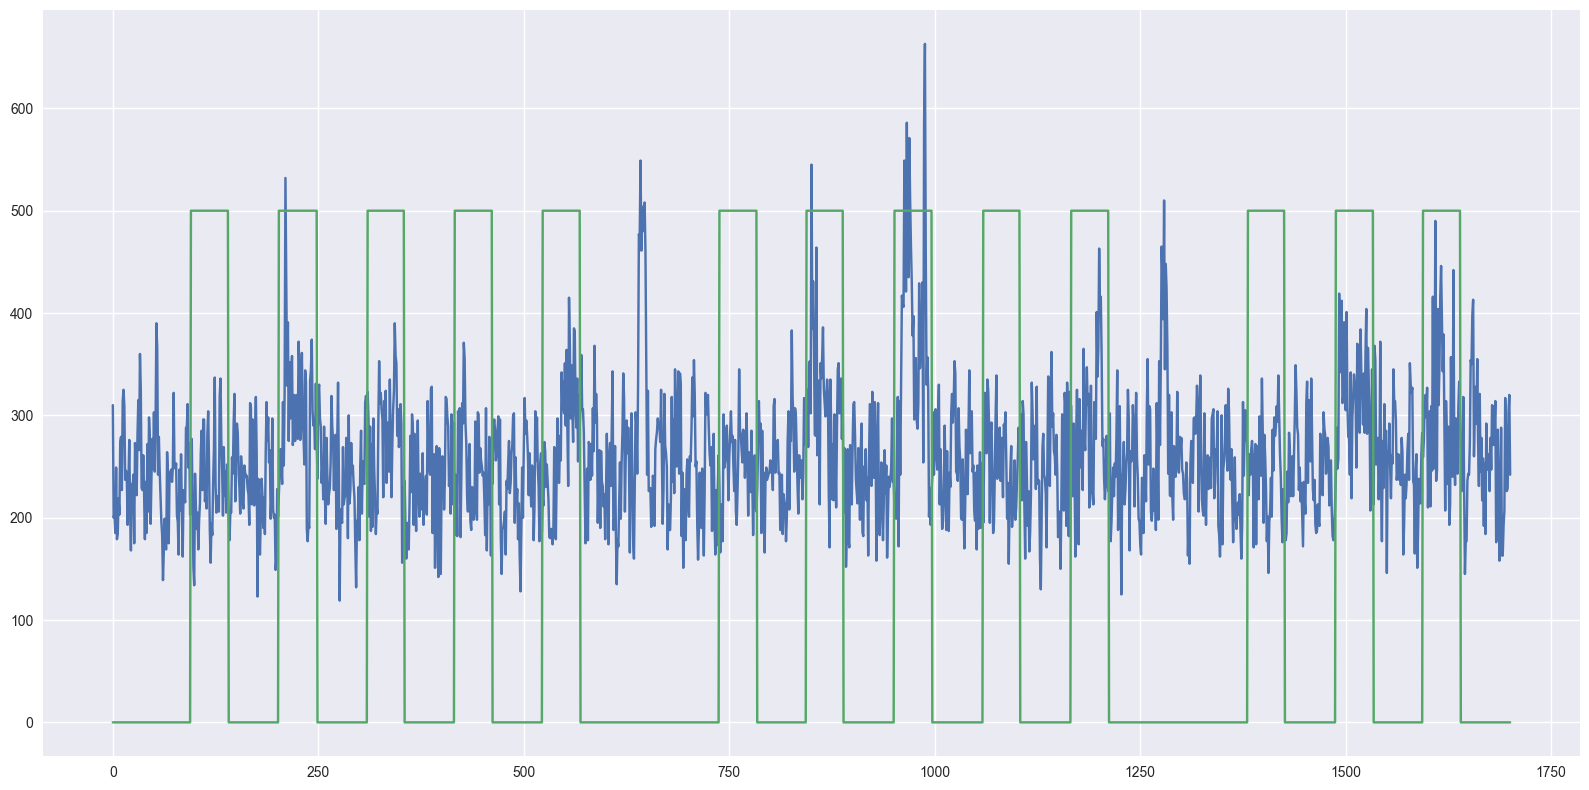

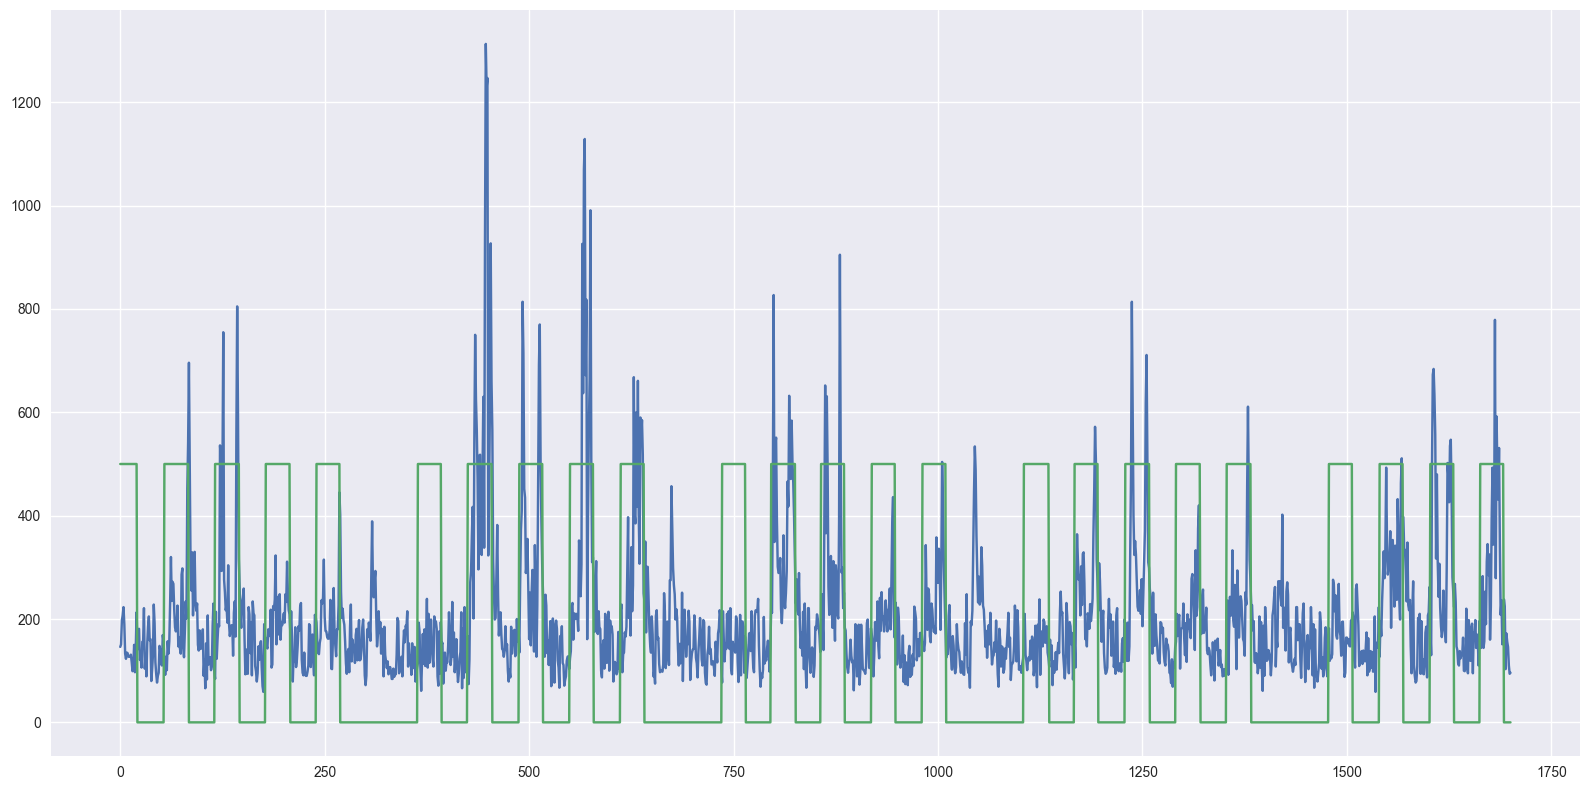

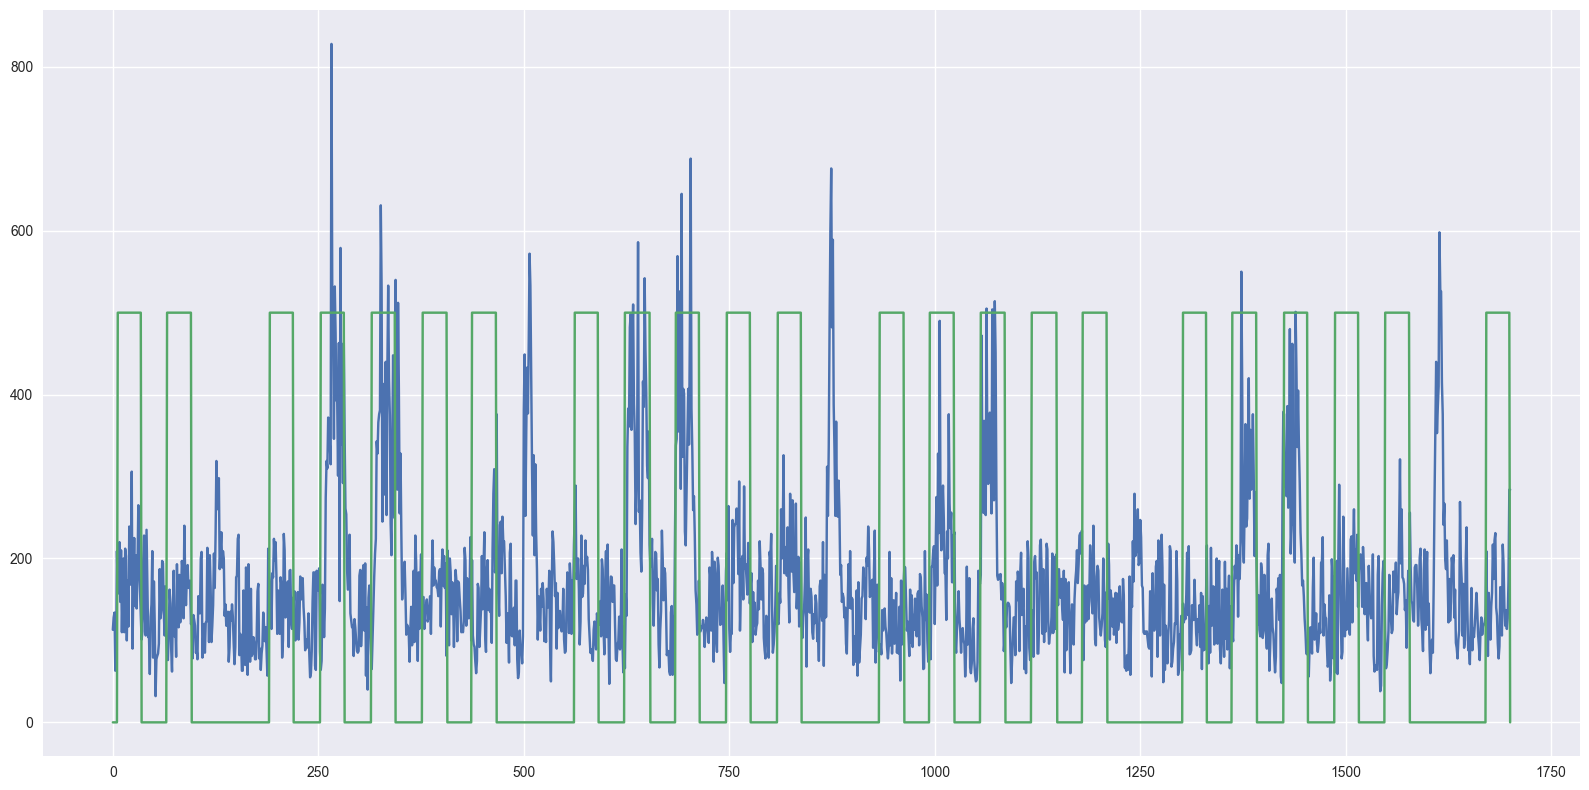

In [111]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('gesture', axis=1) #Матрица наблюдений
    y = data['gesture'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['gesture'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('gesture', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['gesture'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result

#Убираем задержку в наших данных
for idx, data in enumerate(data_list):
    n = get_best_shifter(data, res_plot=True)['n']
    data_list[idx] = data_shifter(data, n)

## Генерация признаков

Сгенерируем признаки с помощью функций реализованных в первом решении.

In [112]:
def get_trend(derivative):
    #Получает тренд из производной
    if derivative > 0:
        return 2
    elif derivative < 0:
        return 1
    else:
        return 0

def create_features(data, n_diff, sum_create=False, trend_create=False, mean_create=False):
    """Изначально создает признаки производных для наших данных, также можно добавить тренды, среднии значения.

    Args:
        data: Наши данные
        n_diff (_type_): Кол-во таймстепов для разницы
        sum_create (bool, optional): Если True, то добавит признак суммы производных. Defaults to False.
        trend_create (bool, optional): Если True, то добавит признаки трендов. Defaults to False.
        mean_create (bool, optional): Если True, то добавит признаки средних. Defaults to False.


    Returns:
        data: Данные со сгенерированными признаками
    """
    #Имена признаков
    col_names = [str(x) for x in range(50)]
    #Для каждого признака добавляем признак производных
    for col in col_names:
        data[f'{col}_diff_{n_diff}'] = data[col].diff(n_diff).fillna(0)
        if trend_create:
            data[f'{col}_trend_{n_diff}'] = data[f'{col}_diff_{n_diff}'].apply(get_trend)
        if mean_create:
            data[f'mean_{n_diff}'] = data.drop('gesture', axis=1).shift(n_diff).mean(axis=1).fillna(0)
        
        
    #Если надо, то добавляем сумму производных 
    if sum_create:
        data[f'sum_diff_{n_diff}'] = data[[f'{col}_diff_{n_diff}' for col in col_names]].sum(axis=1)
    #Возвращаем наши данные
    return data

def get_features(data, n_diff, count, sum_create=False, trend_create=False, mean_create=False):
    #Добавляет признаки к нашим данным от n_diff до n_diff * count отступов
    for i in range(1, count + 1):
        data = create_features(data, n_diff * i, sum_create=sum_create, trend_create=trend_create, mean_create=mean_create)
    #Возвращаем данные со сгенерированными признаками    
    return data

#Генерируем признаки для каждого датасета
for idx, data in enumerate(data_list):
    data_list[idx] = get_features(data, 5, 3, sum_create=True, trend_create=True, mean_create=True)
    
data_list[0].head()

,0,1,2,3,4,5,6,7,8,9,...,45_trend_15,46_diff_15,46_trend_15,47_diff_15,47_trend_15,48_diff_15,48_trend_15,49_diff_15,49_trend_15,sum_diff_15
0,6,4,6,842,1834,1,1384,5,3,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,7,0,6,840,1832,1,1390,4,4,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,25,1,0,837,1828,1,1389,0,5,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,2,4,3,841,1834,0,1392,3,7,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,7,3,1,838,1833,1,1392,0,5,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


## Подготовка данных к подаче в модель
Теперь давайте сформируем тренировочную и тестовую выборки.

In [113]:
#Разделяем данные на обучающие и тестовые
train_data = pd.concat(data_list[:-1], ignore_index=True)
test_data = data_list[-1]
#Формируем матрицы наблюдений
X_train = train_data.drop('gesture', axis=1)
X_test = test_data.drop('gesture', axis=1)
#Формируем вектора правильных ответов
y_train = train_data['gesture']
y_test = test_data['gesture']

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (80602, 356)
Test shape: (22191, 356)


In [114]:
col_names = X_train.columns

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=col_names)

Теперь займемся отбором признаков, реализуем его с помощью SelectKBest.

In [115]:
selector = SelectKBest(f_classif, k=40)
selector.fit(X_train, y_train)

selected_features = selector.get_feature_names_out()
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f'Отобранные признаки: {selector.get_feature_names_out()}')
print(f'Train Data shape: {X_train.shape}')
print(f'Test Data shape: {X_test.shape}')

Отобранные признаки: ['12' '16' '27' '17_trend_5' '30_diff_5' 'sum_diff_5' 'mean_10'
 '5_diff_10' '6_trend_10' '12_diff_10' '12_trend_10' '17_diff_10'
 '17_trend_10' '28_diff_10' '30_diff_10' '30_trend_10' '38_diff_10'
 '39_diff_10' '39_trend_10' 'sum_diff_10' 'mean_15' '3_trend_15'
 '4_trend_15' '5_diff_15' '6_diff_15' '6_trend_15' '12_diff_15'
 '12_trend_15' '17_diff_15' '17_trend_15' '21_diff_15' '28_diff_15'
 '30_diff_15' '30_trend_15' '31_diff_15' '38_diff_15' '38_trend_15'
 '39_diff_15' '39_trend_15' 'sum_diff_15']
Train Data shape: (80602, 40)
Test Data shape: (22191, 40)


## Построение модели

In [118]:
#Модель
dt_model = DecisionTreeClassifier(random_state=random_seed)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
    'criterion': ['gini', 'entropy']
}
#Валидатор
tscv = TimeSeriesSplit(n_splits=5) 
#Подбор гиперпараметров
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train, y_train)
print(f'best params: {grid_dt.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_dt.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_dt.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

best params: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 5}
Train classification report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87     51008
           1       0.89      0.69      0.77      5923
           2       0.64      0.43      0.51      5903
           3       0.65      0.11      0.19      5920
           4       0.68      0.48      0.56      5927
           5       0.84      0.60      0.70      5921

    accuracy                           0.78     80602
   macro avg       0.75      0.54      0.60     80602
weighted avg       0.77      0.78      0.75     80602

Mean-f1 train:  0.6006503621753725
Test classification report:
               precision    recall  f1-score   support

           0       0.60      0.44      0.51     13052
           1       0.08      0.22      0.12      1825
           2       0.10      0.11      0.10      1836
           3       0.13      0.02      0.04      1823
           4     

In [117]:
#Модель
rf_model = RandomForestClassifier(max_depth=11, min_samples_leaf=9, criterion='entropy', random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(30, 300, 30)
}
#Подбор гиперпараметров
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1
)
#Обучаем модель
grid_rf.fit(X_train, y_train)
print(f'best params: {grid_rf.best_params_}')
#Делаем предсказания на тренировочном наборе данных
y_train_predict = grid_rf.predict(X_train)
print(f'Train classification report:\n {metrics.classification_report(y_train, y_train_predict)}')
print(f'Mean-f1 train:  {metrics.f1_score(y_train, y_train_predict, average=None).mean()}')
#Делаем предсказания на тестовом наборе данных
y_test_predict = grid_rf.predict(X_test)
print(f'Test classification report:\n {metrics.classification_report(y_test, y_test_predict)}')
print(f'Mean-f1 test:  {metrics.f1_score(y_test, y_test_predict, average=None).mean()}')

best params: {'n_estimators': 30}
Train classification report:
               precision    recall  f1-score   support

           0       0.49      0.55      0.52      5903
           1       0.95      0.86      0.90      5903
           2       0.84      0.63      0.72      5903
           3       0.58      0.80      0.67      5903
           4       0.75      0.71      0.73      5903
           5       0.90      0.81      0.86      5903

    accuracy                           0.73     35418
   macro avg       0.75      0.73      0.73     35418
weighted avg       0.75      0.73      0.73     35418

Mean-f1 train:  0.733666260607757
Test classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     13052
           1       0.00      0.00      0.00      1825
           2       0.00      0.00      0.00      1836
           3       0.08      1.00      0.15      1823
           4       0.00      0.00      0.00      1822
     